In [ ]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium import spaces
import pygame
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from typing import Optional
import numpy as np
from matplotlib.patches import Circle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GridWorldEnv(gym.Env):
    # 지원하는 렌더링 모드 정의 
    metadata = {"render_modes" : ["human", "rgb_array", "ansi"]}
    # 초기화 함수
    def __init__(self, size: int = 30, max_steps: int = 150, render_mode: Optional[str] = None):

        self.size = size
        # 에이전트와 타겟의 위치를 정의 : reset에서 무작위 선택되고 step에서 업데이트됨 
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
        self._distance = np.array([-1,], dtype=np.float32)

        # 최대 스텝 수 제한을 위한 step
        self._steps = 0
        self.max_steps = max_steps

        # obserbation 정의. 에이전트와 타겟의 위치를 반환
        self.observation_space = gym.spaces.Dict({
            'agent' : gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            'target' : gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            'distance' : gym.spaces.Box(-(size + size), (size + size), shape=(1,), dtype=int)
        })

        # 행동 정의. 현재는 '위, 아래, 오른쪽, 왼쪽' 4개의 행동 
        self.action_space = gym.spaces.Discrete(4)
        # 이산 행동의 행동 결과를 정의
        self._action_to_direction = {
            0 : np.array([1, 0]), # 오른쪽
            1 : np.array([0, 1]), # 위
            2 : np.array([-1, 0]), # 왼쪽
            3 : np.array([0, -1]), # 아래
        }

        # pygame 렌더링 설정
        # if render_mode not in self.metadata["render_modes"]:
        #     raise ValueError(f"render_mode must be one of {self.metadata['render_modes']}, got {render_mode}")
        self.render_mode = render_mode
        self.screen = None
        self.clock = None
        self.cell_size = 30
        self.window_size = (self.size * self.cell_size, self.size * self.cell_size)


    # 에이전트와 타깃의 위치를 반환 
    def _get_obs(self):
        return {'agent': self._agent_location, 'target': self._target_location, 'distance': self._distance}
    # 에이전트와 타깃의 거리를 반환 
    def _get_info(self):
        return {
            'distance': np.linalg.norm(self._agent_location - self._target_location, ord=1) # ord=1 : 맨해튼 거리 반환 
        }
    
    # 환경 초기화 함수
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # reset 오버라이딩
        super().reset(seed=seed)

        # 에이전트 위치를 무작위로 선택. 이때, gym.Env 클래스에 내장된 np_random 객체에 접근하여 난수 생성. np_random 객체는 환경별 난수 생성기
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        # 타겟의 위치를 에이전트 위치와 동일하게 하여 다음 트리거를 확정 
        self._target_location = self._agent_location
        # 타겟 위치를 에이전트 위치와 다르게 할당 
        while np.array_equal(self._agent_location, self._target_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        self._distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        observatioin = self._get_obs()
        info = self._get_info()

        return observatioin, info
    
    # 단계를 진행하는 함수 
    def step(self, action):
        # 단계 한번마다 steps 증가
        self._steps += 1
        # 행동(0, 1, 2, 3 중 하나)을 이동할 방향으로 매핑
        direction = self._action_to_direction[action]
        # np.clip을 사용해 그리드 경계를 벗어나지 못하도록 제한
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        self._distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)

        # 환경 완료 조건 명시 
        terminated = False
        truncated = False
        if np.array_equal(self._agent_location, self._target_location):
            terminated = True
            self._steps = 0
        elif self._steps > self.max_steps:
            truncated = True
            self._steps = 0
        
        # 보상 계산 ######################################################################################################
        reward = 100 if terminated else self._distance * -0.05
        # reward = -np.log(self._distance + 0.000000000000000000000000000000000000001) + 2
        
        # 관찰값 및 정보 생성 
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info    
    
    def render(self):
        if self.render_mode == "human":
            # 창 초기화
            if self.screen is None:
                pygame.init()
                self.screen = pygame.display.set_mode(self.window_size)
                pygame.display.set_caption("GridWorldEnv")
                self.clock = pygame.time.Clock()

            # 이벤트 처리 (창 닫기)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.close()

            # 화면 지우기
            self.screen.fill((255, 255, 255))

            # 그리드 그리기
            for x in range(self.size + 1):
                pygame.draw.line(self.screen, (200, 200, 200),
                                 (x * self.cell_size, 0),
                                 (x * self.cell_size, self.window_size[1]))
            for y in range(self.size + 1):
                pygame.draw.line(self.screen, (200, 200, 200),
                                 (0, y * self.cell_size),
                                 (self.window_size[0], y * self.cell_size))
                
            # 에이전트와 타겟 그리기
            agent_pos = (self._agent_location[0] * self.cell_size + self.cell_size // 2,
                         self._agent_location[1] * self.cell_size + self.cell_size // 2)
            target_pos = (self._target_location[0] * self.cell_size + self.cell_size // 2,
                          self._target_location[1] * self.cell_size + self.cell_size // 2)
            pygame.draw.circle(self.screen, (0, 0, 255), agent_pos, self.cell_size // 4)  # 파란색 에이전트
            pygame.draw.circle(self.screen, (255, 0, 0), target_pos, self.cell_size // 4)  # 빨간색 타겟

            # 화면 업데이트
            pygame.display.flip()
            # pygame.time.delay(5)
            self.clock.tick(20)  # FPS 30으로 제한

        elif self.render_mode == "rgb_array":
            # rgb_array 구현 (필요 시)
            pass

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None




In [23]:
gym.register(
    id="gymnasium_env/GridWorld-v0",
    entry_point=GridWorldEnv,
)

env = gym.make("gymnasium_env/GridWorld-v0", render_mode = "human")
env = FlattenObservation(env)

/root/miniconda3/envs/torch_env/lib/python3.11/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment gymnasium_env/GridWorld-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [24]:
state, info = env.reset()
print(state, info)
# print(-np.log(state[4] + 1))

[29 20 10 21 18] {'distance': np.float64(10.0)}


/root/miniconda3/envs/torch_env/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'numpy.float64'>
  logger.warn(
/root/miniconda3/envs/torch_env/lib/python3.11/site-packages/gymnasium/spaces/box.py:423: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/root/miniconda3/envs/torch_env/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [25]:
# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 환경에서 단일 전환을 나타내도록 명명된 튜플. (state, action) 쌍을 (next_state, reaward) 결과로 매핑
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# 최근 관찰된 전이를 보관 유지하는 제한된 크기의 순환 버퍼. 또한 학습을 위한 전환의 무작위 배치를 선택하기 위한 sample() 메서드 구현
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [26]:
state, info = env.reset()
print(f'state: {state}, info: {info}')

state: [28 19 25  4 18], info: {'distance': np.float64(25.0)}


In [27]:
# BATCH_SIZE는 리플레이 버퍼에서 샘플링된 트랜지션의 수입니다.
# GAMMA는 이전 섹션에서 언급한 할인 계수입니다.
# EPS_START는 엡실론의 시작 값입니다.
# EPS_END는 엡실론의 최종 값입니다.
# EPS_DECAY는 엡실론의 지수 감쇠(exponential decay) 속도 제어하며, 높을수록 감쇠 속도가 느립니다.
# TAU는 목표 네트워크의 업데이트 속도입니다.
# LR은 ``AdamW`` 옵티마이저의 학습율(learning rate)입니다.
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 50000
TAU = 0.01
LR = 0.001

In [28]:
# 현재와 이전 스크린 패치의 차이를 취하는 순연결 신경망
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, BATCH_SIZE)
        self.layer2 = nn.Linear(BATCH_SIZE, BATCH_SIZE)
        self.layer3 = nn.Linear(BATCH_SIZE, n_actions)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [29]:
# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
# 상태 관측 횟수를 얻습니다.
state, info = env.reset()
n_observations = len(state)

print(n_actions, n_observations)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(50000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

4 5


In [30]:

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # print(f'non final mask: {non_final_mask}')
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    # print(f'non final mask: {non_final_next_states}')
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1).values로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    # 변화도 클리핑 바꿔치기
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


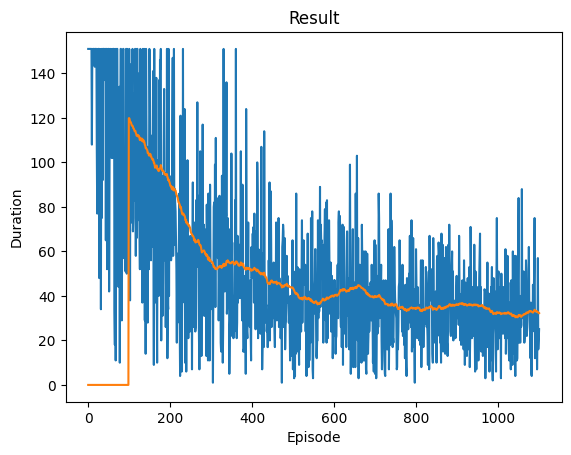

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
if torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        # env.render()
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            # env.close()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [32]:
steps_done

11987